In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

import copy
import math
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import SequentialLR, LinearLR, ExponentialLR, CosineAnnealingLR
from torch.utils.data import DataLoader, Subset, random_split

# from data_utils import *
from balanced_data_utils import *
from data_utils import *
from model import *
from waveforms.waveforms_module.make_waveform import BatchedLightSimulation

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

g = torch.Generator()
g.manual_seed(seed)

In [2]:
def test_rebalance_dataloaders(path, batch_size=25, val_ratio=0.1, test_ratio=0.0, 
                        generator=None, balanced=True, base_indices=None):
    load_wfs = np.load(path, allow_pickle=True)
    full_data = load_wfs.item()

    # Keep both dataset classes consistent in indexing
    if balanced:
        dataset = BalancedWaveformDataset(full_data)
    else:
        dataset = WaveformDataset(full_data)

    total_size = len(dataset)
    val_size = int(total_size * val_ratio)
    test_size = int(total_size * test_ratio)
    train_size = total_size - val_size - test_size

    # Reuse same index split for both balanced/unbalanced
    if base_indices is None:
        train_dataset, val_dataset, test_dataset = random_split(
            dataset, [train_size, val_size, test_size], generator=generator
        )
        base_indices = (train_dataset.indices, val_dataset.indices, test_dataset.indices)
    else:
        # Reuse indices to maintain same order
        train_dataset = torch.utils.data.Subset(dataset, base_indices[0])
        val_dataset = torch.utils.data.Subset(dataset, base_indices[1])
        test_dataset = torch.utils.data.Subset(dataset, base_indices[2])

    collate_fn = labelled_collate_fn

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False,  # no shuffle for identical order
        collate_fn=collate_fn, generator=generator
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader, base_indices


In [ ]:
path = '/sdf/home/c/carsmith/sdf_data/self_supervised_flash/data/test.npy'

# Create indices once
train_loader_unbal, val_loader_unbal, test_loader_unbal, base_idx = test_rebalance_dataloaders(
    path, generator=g, balanced=False
)

# Reuse the exact same indices
train_loader_bal, val_loader_bal, test_loader_bal, _ = test_rebalance_dataloaders(
    path, generator=g, balanced=True, base_indices=base_idx
)

In [ ]:
import matplotlib.pyplot as plt
import torch
from matplotlib.gridspec import GridSpec

def plot_waveform(ax, wf, hit_times, idx):
    ticks = torch.arange(wf.shape[-1])
    wf = wf.squeeze(0)

    ax.plot(ticks, wf, alpha=1)

    for j, t in enumerate(hit_times):
        if t >= 0:
            ax.axvline(
                x=t.item(),
                color='r',
                linestyle='--',
                linewidth=2,
                label="True arrival" if j == 0 else ""
            )

    ax.set_ylabel("ADC")
    ax.set_title(f"Waveform {idx}")
    ax.legend(loc='upper right', fontsize=8)


# --------------------------------------------------------------
# Get 5 waveforms from each dataloader
# --------------------------------------------------------------
bal_batch = next(iter(val_loader_bal))
unbal_batch = next(iter(val_loader_unbal))

bal_waveforms, bal_hit_times = bal_batch[0], bal_batch[2]
unbal_waveforms, unbal_hit_times = unbal_batch[0], unbal_batch[2]

N = 5
bal_waveforms = bal_waveforms[:N]
bal_hit_times = bal_hit_times[:N]
unbal_waveforms = unbal_waveforms[:N]
unbal_hit_times = unbal_hit_times[:N]


# --------------------------------------------------------------
# Figure: 5 rows × 2 columns (no sub-panels)
# --------------------------------------------------------------
fig = plt.figure(figsize=(12, 14))
outer_gs = GridSpec(N, 2, figure=fig, hspace=0.4, wspace=0.25)

for row in range(N):
    # Left column: unbalanced
    ax_left = fig.add_subplot(outer_gs[row, 0])
    plot_waveform(ax_left,
                  unbal_waveforms[row],
                  unbal_hit_times[row],
                  idx=row)

    # Right column: balanced
    ax_right = fig.add_subplot(outer_gs[row, 1])
    plot_waveform(ax_right,
                  bal_waveforms[row],
                  bal_hit_times[row],
                  idx=row)

fig.suptitle("Unbalanced (Left) vs Balanced (Right)", fontsize=18)
plt.show()


In [5]:
import torch
from collections import Counter

label_counts = Counter()

for batch in train_loader_bal:
    *_, token_labels = batch   # shape [B, L]

    # Flatten from [B, L] → [B*L]
    labels_flat = token_labels.reshape(-1).cpu().tolist()

    # Update global counter
    label_counts.update(labels_flat)

print("Token counts:", label_counts)

Token counts: Counter({0: 3520882, 2: 2288737, 1: 175381})


In [6]:
print(token_labels[4])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [3]:
# path = '/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8_200k_labels.npy'
# train_loader, val_loader, test_loader = make_wf_dataloaders(path, generator=g, balanced=True)

/sdf/home/c/carsmith/flash_reconstruction/self_supervised_flash/balanced_data_utils.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  token_labels = torch.tensor(data['token_labels']).int()   # shape [N, L_token]


In [9]:
print(len(train_loader_unbal))

360


Batch shape:  torch.Size([25, 1, 4100])
Arrival times shape:  torch.Size([25, 1, 4100])
Photon bins shape:  torch.Size([25, 1, 4100])
Total photons in wf:  2700


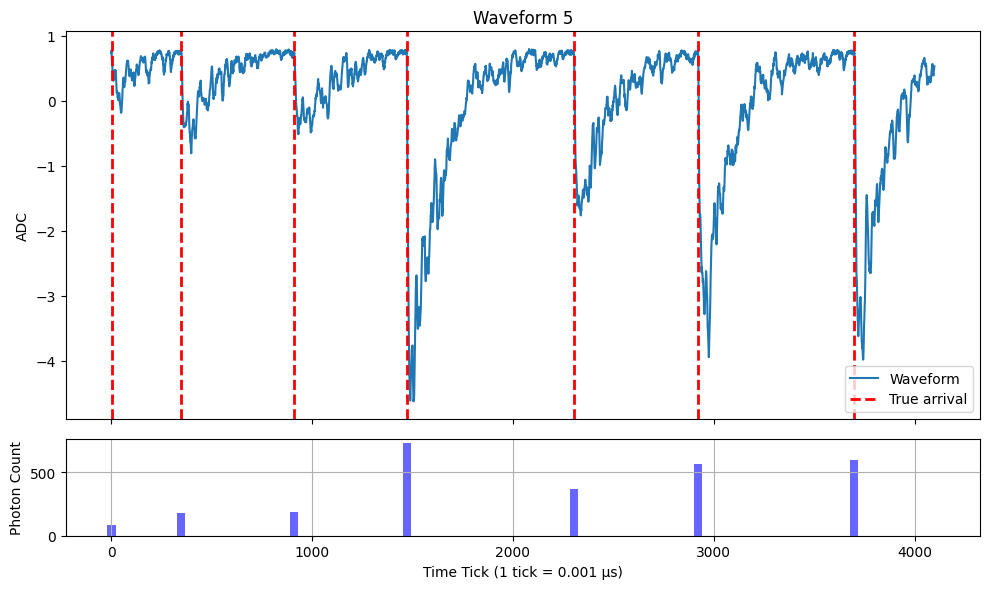

In [43]:
waveforms, arrival_times, hit_times, photon_bins, photon_list, token_labels = next(iter(val_loader_bal))
print('Batch shape: ', waveforms.shape)
print('Arrival times shape: ', arrival_times.shape)
print('Photon bins shape: ', photon_bins.shape)

waveform_id = 5
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True,
    gridspec_kw={'height_ratios': [4, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label='Waveform')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=2, 
            label='True arrival' if j == 0 else ""
        )

ax1.set_title(f"Waveform {waveform_id}")
ax1.set_ylabel("ADC")
ax1.legend()

# --- Bottom panel: photon counts ---
photon_counts = photon_bins[waveform_id].cpu().numpy()
print("Total photons in wf: ", photon_counts[0].sum())
ax2.bar(ticks, photon_counts[0], width=40.0, color='b', alpha=0.6)
ax2.set_ylabel("Photon Count")
ax2.set_xlabel("Time Tick (1 tick = 0.001 μs)")
ax2.grid()
plt.tight_layout()
plt.show()

In [40]:
print(hit_times[4])

tensor([ 117,  699, 1199, 2626, 3708, 4489,   -1,   -1])


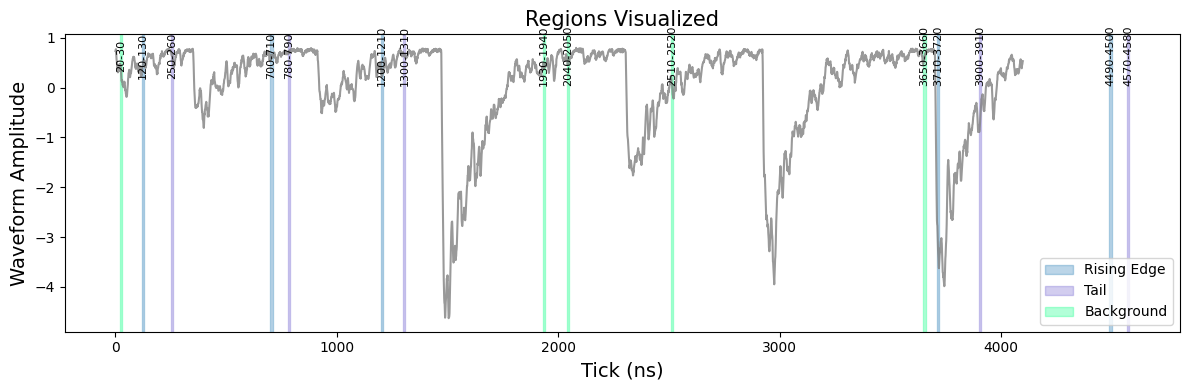

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# windows
rising_edge_windows = np.array([[120, 130], [700, 710], [1200, 1210], [3710, 3720], [4490, 4500]])
tail_windows = np.array([[250, 260], [780, 790], [1300, 1310], [3900, 3910], [4570, 4580]])
background_windows = np.array([[3650, 3660], [20, 30], [1930, 1940], [2040, 2050], [2510, 2520]])

plt.figure(figsize=(12, 4))
plt.plot(ticks, wf, color='gray', alpha=0.8)
for i, (start, end) in enumerate(rising_edge_windows):
    if i == 0:
        plt.axvspan(start, end, color='C0', alpha=0.3, label='Rising Edge')
    else:
        plt.axvspan(start, end, color='C0', alpha=0.3)
    plt.text((start+end)/2, torch.max(wf)*0.8, f"{start}-{end}", rotation=90, ha='center', va='center', fontsize=8)
for i, (start, end) in enumerate(tail_windows):
    if i == 0:
        plt.axvspan(start, end, color='slateblue', alpha=0.3, label='Tail')
    else:
        plt.axvspan(start, end, color='slateblue', alpha=0.3)
    plt.text((start+end)/2, torch.max(wf)*0.8, f"{start}-{end}", rotation=90, ha='center', va='center', fontsize=8)
for i, (start, end) in enumerate(background_windows):
    if i == 0:
        plt.axvspan(start, end, color='springgreen', alpha=0.3, label='Background')
    else: 
         plt.axvspan(start, end, color='springgreen', alpha=0.3)
    plt.text((start+end)/2, torch.max(wf)*0.8, f"{start}-{end}", rotation=90, ha='center', va='center', fontsize=8)

# axes[0].set_ylabel("Waveform Amplitude")
plt.ylabel("Waveform Amplitude", fontsize=14)
plt.xlabel("Tick (ns)", fontsize=14)
plt.title("Regions Visualized", fontsize=15)
plt.tight_layout()
plt.legend()
plt.show()

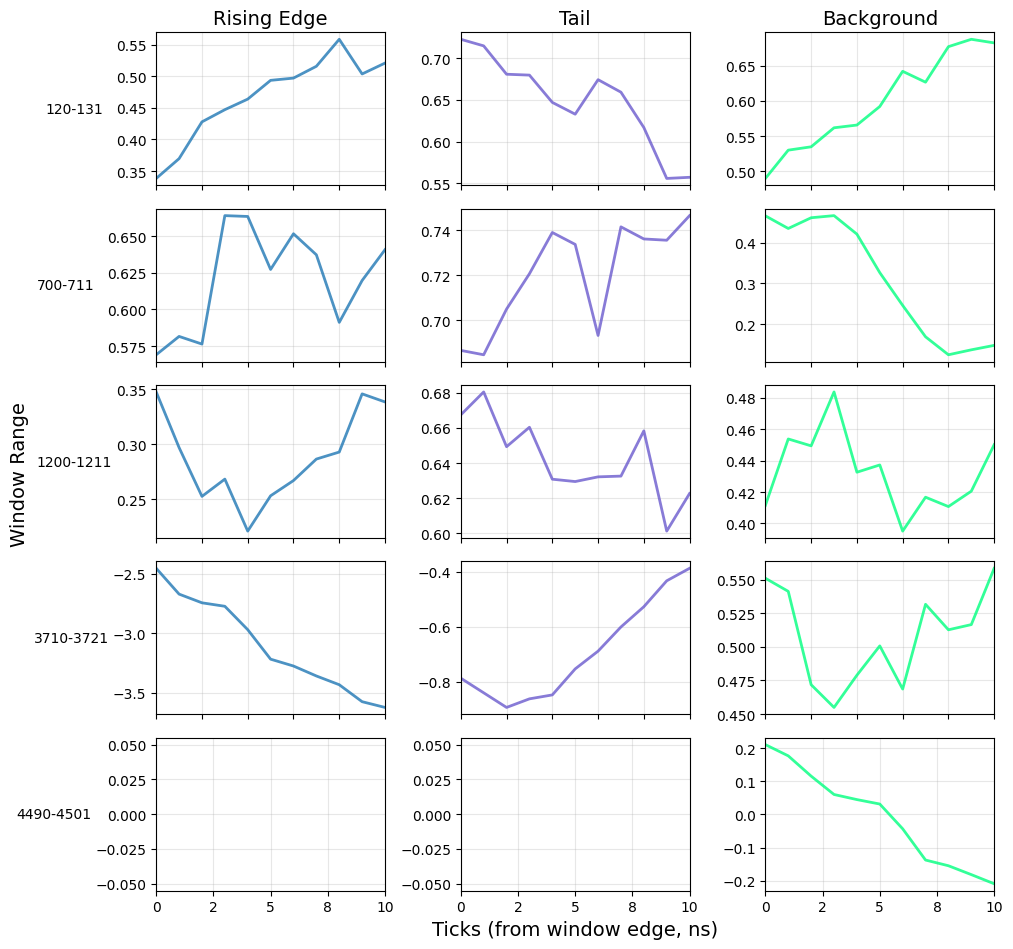

In [45]:
import numpy as np
import matplotlib.pyplot as plt

categories = [
    ("Rising Edge", rising_edge_windows),
    ("Tail", tail_windows),
    ("Background", background_windows)
]

n_rows = len(rising_edge_windows)
n_cols = len(categories)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 2 * n_rows), sharey=False, sharex=False)

# Ensure axes is 2D array
axes = np.array(axes).reshape(n_rows, n_cols)

for col, (title, windows) in enumerate(categories):
    for row, (start, end) in enumerate(windows):
        ax = axes[row, col]
        if title == "Rising Edge": color='C0'
        elif title == "Tail": color = 'slateblue'
        else: color = 'springgreen'
            
        ax.plot(ticks[start:end+1], wf[start:end+1], color=color, alpha=0.8, linewidth=2)
        ax.set_xlim(start, end)
        ax.grid(True, alpha=0.3)

        if col == 0:
            ax.set_ylabel(f"{start}-{end+1}", rotation=0, labelpad=30, va='center')
        if row == 0:
            ax.set_title(title, fontsize=14)

        if row < n_rows - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.linspace(start, end, 5))
            ax.set_xticklabels([f"{x - start:.0f}" for x in np.linspace(start, end, 5)])
            # ax.set_xlabel("Ticks (relative)")

axes[-1, 1].set_xlabel("Ticks (from window edge, ns)", fontsize=14)
fig.text(0.04, 0.5, "Window Range", va='center', rotation='vertical', fontsize=14)
plt.tight_layout(rect=[0.04, 0.02, 1, 0.98])
plt.show()

In [8]:
from data_utils import *
path = '/sdf/home/c/carsmith/sdf_data/self_supervised_flash/data/200k_3labels.npy'
train_loader, val_loader, test_loader = make_wf_dataloaders(path, batch_size=25, val_ratio=0.1, test_ratio=0, generator=g, norm=False)

data keys: dict_keys(['waveforms', 'arrival_times', 'num_photons', 'token_labels', 'last_phot_arrival'])


Batch shape:  torch.Size([25, 1, 8000])
Arrival times shape:  torch.Size([25, 1, 8000])
Photon bins shape:  torch.Size([25, 1, 8000])
Total photons in wf:  1279


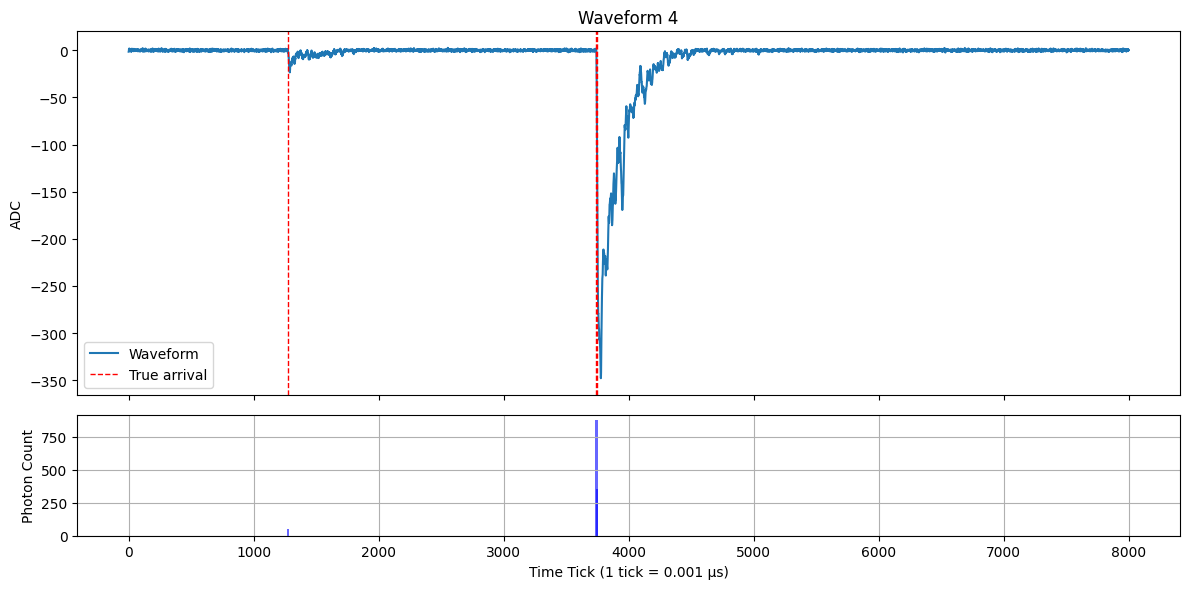

In [12]:
waveforms, arrival_times, hit_times, photon_bins, photon_list, _, token_labels = next(iter(val_loader))
print('Batch shape: ', waveforms.shape)
print('Arrival times shape: ', arrival_times.shape)
print('Photon bins shape: ', photon_bins.shape)

waveform_id = 4
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label='Waveform')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

ax1.set_title(f"Waveform {waveform_id}")
ax1.set_ylabel("ADC")
ax1.legend()

# --- Bottom panel: photon counts ---
photon_counts = photon_bins[waveform_id].cpu().numpy()
print("Total photons in wf: ", photon_counts[0].sum())
ax2.bar(ticks, photon_counts[0], width=20.0, color='b', alpha=0.6)
ax2.set_ylabel("Photon Count")
ax2.set_xlabel("Time Tick (1 tick = 0.001 μs)")
ax2.grid()
plt.tight_layout()
plt.show()

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# student = ConformerModel()
# teacher = copy.deepcopy(student) # identical starting weights
# student, teacher = student.to(device), teacher.to(device)
# total_params = sum(p.numel() for p in student.parameters())
# print(f"Total number of parameters: {total_params:,}")

torch.Size([25, 1, 4940])
torch.Size([25, 256, 494])


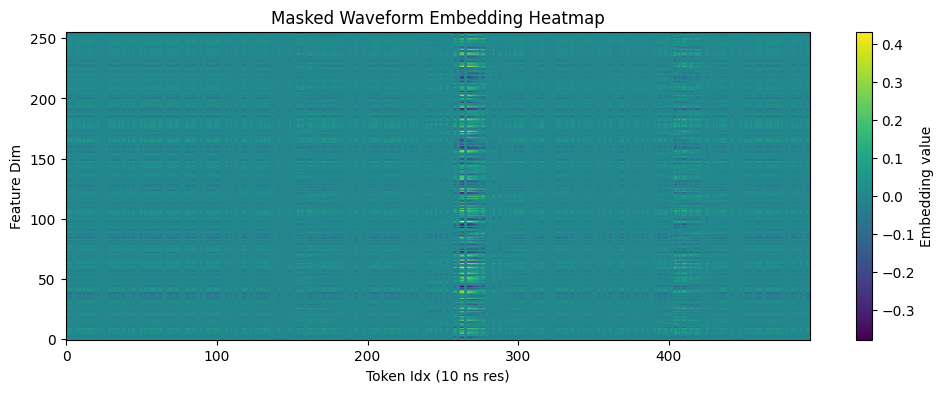

In [9]:
# Inspect 
import matplotlib.cm as cm

print(waveforms.shape)

tokenizer = MultiLevelTokenizer(
                in_channels=1,
                hidden_dim=256,
                kernel_sizes=[20, 50, 100, 400],
                window_len=8000,
                token_size=10,
                downsample='conv_mlp_lite'
            )

pos_encoder = PositionalEncoding(d_model=256, max_len=8000)

x = tokenizer(waveforms)
waveformMask = RandomMasking(masking_p=0.5)
_, masked_wfs = waveformMask(x) #[25, 256, 800]

print(masked_wfs.shape)
x = masked_wfs[waveform_id]

x_np = x.detach().cpu().numpy()  # convert to numpy if it's a tensor

# viridis = cm.get_cmap("viridis")
# colored = viridis((x_np - x_np.min()) / (x_np.max() - x_np.min()))
# colored[x_np == 0] = [1, 0, 0, 1]

plt.figure(figsize=(12, 4))
plt.imshow(x_np, aspect='auto', origin='lower', cmap='viridis')
# plt.imshow(colored, aspect='auto', origin='lower')
plt.colorbar(label='Embedding value')
plt.xlabel('Token Idx (10 ns res)')
plt.ylabel('Feature Dim')
plt.title('Masked Waveform Embedding Heatmap')
plt.show()

(256, 4940)


Text(0, 0.5, 'Feature Dim')

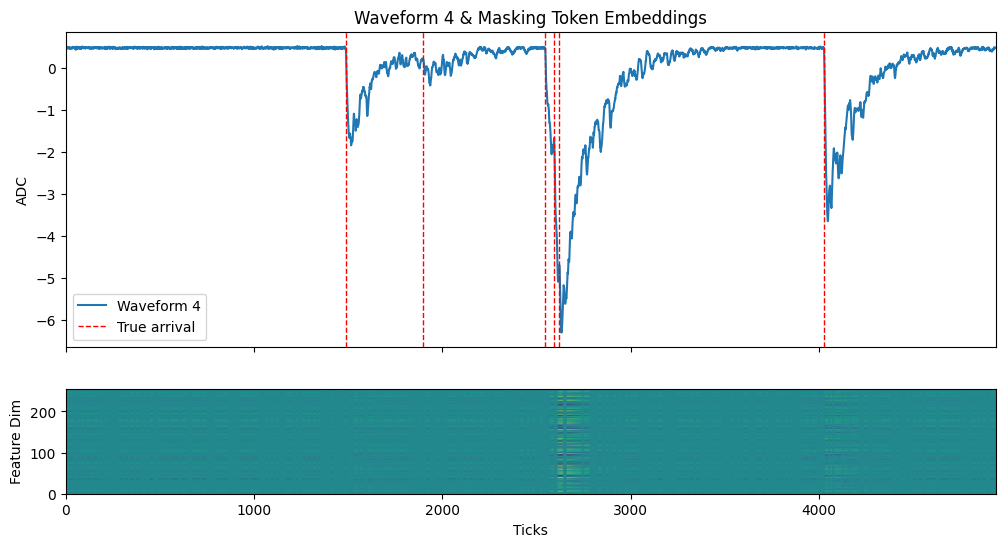

In [13]:
waveform_id = 4
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label=f'Waveform {waveform_id}')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

ax1.set_title(f"Waveform {waveform_id} & Masking Token Embeddings")
ax1.set_ylabel("ADC")
ax1.legend()
x_np_repeated = np.repeat(x_np, repeats=10, axis=1)
print(x_np_repeated.shape)
ax2.imshow(x_np_repeated, aspect='auto', origin='lower', cmap='viridis')
ax2.set_xlabel("Ticks")
ax2.set_ylabel("Feature Dim")

### Ponder the results

In [6]:
# Load the checkpoint
device = 'cuda'
model = ConformerModel()
model.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/self_supervised_flash/dino_mask50_token10_5epochs.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ConformerModel(
  (tokenizer): MultiLevelTokenizer(
    (convs): ModuleList(
      (0): Conv1d(1, 256, kernel_size=(20,), stride=(1,), padding=(10,))
      (1): Conv1d(1, 256, kernel_size=(50,), stride=(1,), padding=(25,))
      (2): Conv1d(1, 256, kernel_size=(100,), stride=(1,), padding=(50,))
      (3): Conv1d(1, 256, kernel_size=(400,), stride=(1,), padding=(200,))
    )
    (downsample): Sequential(
      (0): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): GELU(approximate='none')
      (2): Conv1d(256, 256, kernel_size=(10,), stride=(10,), groups=256, bias=False)
      (3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (proj): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
  )
  (positional_encoding): PositionalEncoding()
  (conformer): Conformer(
    (conformer_layers): ModuleList(
      (0-3): 4 x ConformerLayer(
        (ffn1): _FeedForwardModule(
          (sequential): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwi

#### Silhouette Score (Clustering)

In [7]:
# Extract some embeddings
from sklearn.metrics import silhouette_score, adjusted_rand_score

val_progress = tqdm(val_loader, desc="Scanning", leave=False, position=0)

all_val_embeddings = []

with torch.no_grad():
    for data, target, hit_times, photon_target, photon_list in val_progress:
        data = data.to(device)
        embeddings = model(data)
        all_val_embeddings.append(embeddings.cpu())  # store on CPU to save GPU memory

all_val_embeddings = torch.cat(all_val_embeddings, dim=0)

In [8]:
print(all_val_embeddings.shape)

torch.Size([20000, 800, 20])


In [9]:
# Cluster and calculate a silhouette score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

B, T, D = all_val_embeddings.shape
X = all_val_embeddings.reshape(B * T, D) # consider cluster for all tokens independently

X = StandardScaler().fit_transform(X)

idx = torch.randperm(B*T)[:100000]
X_subset = X[idx]

n_clusters = 7
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000, random_state=42)
cluster_labels = kmeans.fit_predict(X_subset)

sil_score = silhouette_score(X_subset, cluster_labels)
print(f"Silhouette score for {n_clusters} clusters: {sil_score:.3f}")

Silhouette score for 7 clusters: 0.358


[0 1 2 3 4 5 6]


Text(0, 0.5, 'Silhouette Score')

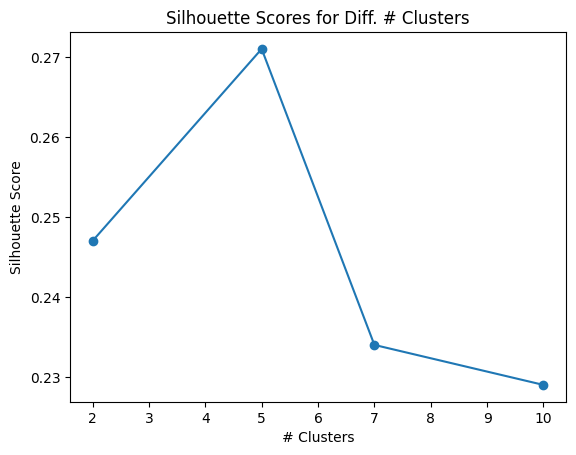

In [10]:
print(np.unique(cluster_labels))
# 10 clusters: 0.229
# 7 clusters: 0.234
# 5 clusters: 0.271
# 2 clusters: 0.247
n_clusters = [2, 5, 7, 10]
scores = [0.247, 0.271, 0.234, 0.229]
plt.plot(n_clusters, scores, marker='o')
plt.title("Silhouette Scores for Diff. # Clusters")
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Score")

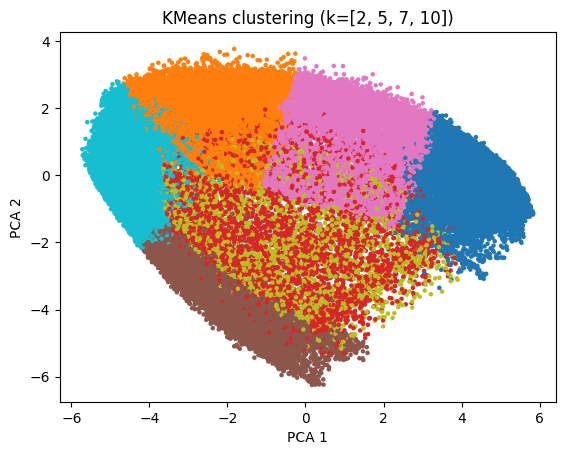

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_pca = PCA(n_components=2).fit_transform(X_subset)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=5)
plt.title(f"KMeans clustering (k={n_clusters})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [3]:
mae_test(student, train_loader, val_loader, optimizer, scheduler, epochs, device, logger=None) 

tensor(0.8787)
val_accuracy_class_0:  tensor(0.9738)
val_accuracy_class_1:  tensor(0.9468)
val_accuracy_class_2:  tensor(0.7624)


In [14]:
print(all_preds.flatten()[:10])
print(all_labels.flatten()[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=torch.int32)


Text(0.5, 1.0, 'Normalized Waveform')

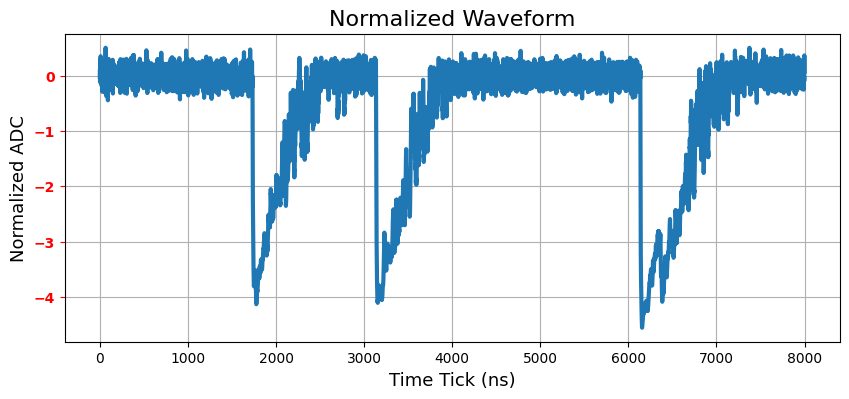

In [31]:
plt.figure(figsize=(10, 4))
data = waveforms[5].squeeze(1)
wf = data[0].detach().cpu()
# wf_unnorm = 5 * torch.sinh(wf)
wf_norm = torch.arcsinh(wf / 5)
plt.plot(wf_norm, linewidth=3)
plt.tick_params(axis='y', colors='red')
for label in plt.gca().get_yticklabels():
    label.set_fontweight('bold')
plt.grid(which='both')
plt.xlabel("Time Tick (ns)", fontsize=13)
plt.ylabel("Normalized ADC", fontsize=13)
plt.title("Normalized Waveform", fontsize=16)

norm rms:  tensor(0.1399)
unnorm rms:  tensor(0.7061)
eot 10 rms:  tensor(0.4800)
eot 30 rms:  tensor(0.4513)
eot 50 rms:  tensor(0.4039)
eot 100 rms:  tensor(0.3819)
eot 200 rms:  tensor(0.3845)
eot 300 rms:  tensor(0.3856)
eot 400 rms:  tensor(0.3763)
eot 500 rms:  tensor(0.3996)


/lscratch/carsmith/tmp/ipykernel_806284/165644513.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  bg_unnorm = 5 * np.sinh(bg_reg)


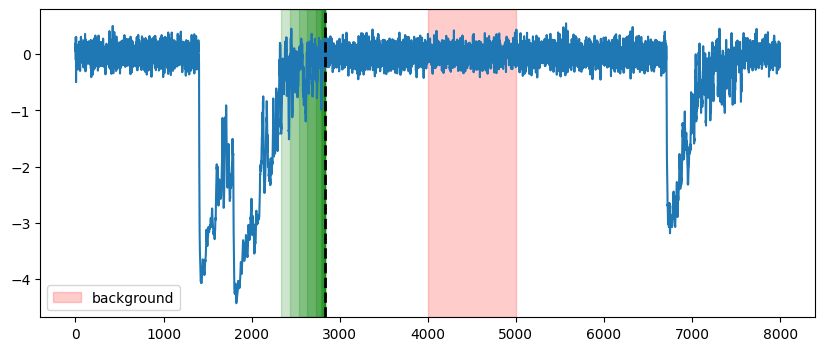

In [75]:
plt.figure(figsize=(10, 4))
data = data.squeeze(1)
wf = data[0].detach().cpu()
wf_unnorm = 5 * torch.sinh(wf)
plt.plot(wf)

bg_reg = wf[4000:5000]
bg_unnorm = 5 * np.sinh(bg_reg)
plt.axvspan(4000, 5000, color='red', alpha=0.2, label='background')
norm_rms = torch.sqrt(torch.mean(bg_reg**2))
unnorm_rms = torch.sqrt(torch.mean(bg_unnorm**2))
print("norm rms: ", norm_rms)
print("unnorm rms: ", unnorm_rms)
plt.axvline(eot, color='black', linestyle='--', linewidth=2)

eot = int(last_phot_list[0][1].item()) + 47
reg_size = 500

# tail_rms = []
# unnorm_tail_rms = []
m0s1_tail_rms = []
wf_m0s1 = (wf - wf.mean()) / (wf.std() + 1e-8)

tail_regions = [10, 30, 50, 100, 200, 300, 400, 500]

for reg_size in tail_regions:
    eot_reg = wf_m0s1[(eot - reg_size) : eot]
    plt.axvspan(eot - reg_size, eot, color='green', alpha=0.2)
    eot_rms = torch.sqrt(torch.mean(eot_reg**2))
    print(f"eot {reg_size} rms: ", eot_rms)
    m0s1_tail_rms.append(eot_rms)

plt.legend()

In [77]:
m0s1_unnorm_rms = torch.sqrt(torch.mean(wf_m0s1[4000:5000]**2))


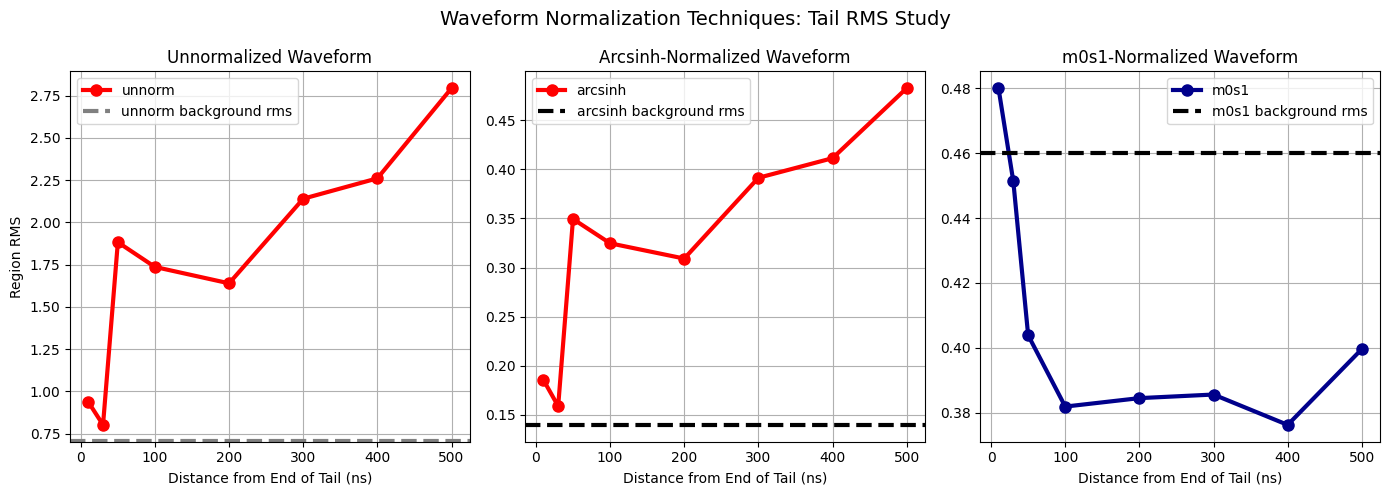

In [78]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# --- Unnormalized data ---
ax = axes[0]
ax.plot(tail_regions, unnorm_tail_rms, marker='o', markersize=8,
        linewidth=3, color='red', label='unnorm')
ax.axhline(unnorm_rms, linestyle='--', color='gray', linewidth=3,
           label='unnorm background rms')
ax.set_title("Unnormalized Waveform")
ax.set_xlabel("Distance from End of Tail (ns)")
ax.set_ylabel("Region RMS")
ax.grid()
ax.legend()

# --- Arcsinh data ---
ax = axes[1]
ax.plot(tail_regions, tail_rms, marker='o', markersize=8,
        linewidth=3, color='red', label='arcsinh')
ax.axhline(norm_rms, linestyle='--', color='black', linewidth=3,
           label='arcsinh background rms')
ax.set_title("Arcsinh-Normalized Waveform")
ax.set_xlabel("Distance from End of Tail (ns)")
ax.grid()
ax.legend()

# --- m0s1 data ---
ax = axes[2]
ax.plot(tail_regions, m0s1_tail_rms, marker='o', markersize=8, linewidth=3, color='darkblue', label='m0s1')
ax.axhline(m0s1_unnorm_rms, linestyle='--', color='black', linewidth=3,
           label='m0s1 background rms')
ax.set_title("m0s1-Normalized Waveform")
ax.set_xlabel("Distance from End of Tail (ns)")
ax.grid()
ax.legend()

plt.suptitle("Waveform Normalization Techniques: Tail RMS Study", fontsize=14)
plt.tight_layout()
plt.show()